In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')

def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")
sub = pd.read_csv(f"{path}/sample_submission.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    return df2

train_fe = feature_engineering(train)
test_fe = feature_engineering(test)
train_fe.shape, test_fe.shape

((2266586, 27), (260114, 27))

In [2]:
train_fe['kind']='train'
test_fe['kind']='test'
df = pd.concat([train_fe,test_fe])

## 전체 데이터

### 문제푼시간 초단위 측정 및 내보내기

In [3]:
df[:2]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Timestamp2,solvetime,solvesec,solvesec_3600,...,big_category,problem_num,mid_category,test_mean,test_std,test_sum,tag_mean,tag_std,tag_sum,kind
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,2020-03-24 00:17:11,0 days 00:00:00,0.0,0.0,...,6,1,1,0.947683,0.222749,1268,0.955022,0.207410,637,train
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2020-03-24 00:17:14,0 days 00:00:03,3.0,3.0,...,6,2,1,0.947683,0.222749,1268,0.913187,0.281603,3040,train


In [4]:
df = df.sort_values(['userID','Timestamp'])

df.reset_index(drop=True,inplace=True)

df['Timestamp2'] = pd.to_datetime(df.Timestamp)
df['solvetime'] = df.groupby(['userID','testId'])['Timestamp2'].diff()
df['solvesec'] = df.solvetime.map(lambda x : x.total_seconds())

df.solvesec.describe()

count    2.119511e+06
mean     1.707574e+04
std      3.872213e+05
min      0.000000e+00
25%      1.000000e+01
50%      2.700000e+01
75%      6.600000e+01
max      2.869588e+07
Name: solvesec, dtype: float64

## 3600초, 3200, 2400, 1800, 1200, 800, 600 이상 변환

In [6]:
df['solvesec_3600'] = df.solvesec
df.loc[df.solvesec>=3600,'solvesec_3600']=3600

In [7]:
df['solvesec_3200'] = df.solvesec
df.loc[df.solvesec>=3200,'solvesec_3200']=3200

In [20]:
df['solvesec_2400'] = df.solvesec
df.loc[df.solvesec>=2400,'solvesec_2400']=2400

In [9]:
df['solvesec_1800'] = df.solvesec
df.loc[df.solvesec>=1800,'solvesec_1800']=1800

In [10]:
df['solvesec_1200'] = df.solvesec
df.loc[df.solvesec>=1200,'solvesec_1200']=1200

In [11]:
df['solvesec_800'] = df.solvesec
df.loc[df.solvesec>=800,'solvesec_800']=800

In [12]:
df['solvesec_600'] = df.solvesec
df.loc[df.solvesec>=600,'solvesec_600']=600

In [18]:
# 문제푼 시간 초단위 측정 내보내기
df2 = df.drop(['Timestamp2','solvetime'],axis=1)
export(df2,output='after_fe_train_test_solvetime_user_test.pkl')

Write: /opt/ml/input/data/after_fe_train_test_solvetime_user_test.pkl


In [25]:
df[df.solvesec_2400>2000]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Timestamp2,solvetime,solvesec,solvesec_3600,...,tag_std,tag_sum,kind,solvesec_3200,solvesec400,solvesec_1800,solvesec_1200,solvesec_800,solvesec_600,solvesec_2400
357,0,A060078004,A060000078,1,2020-07-02 03:03:12,9590,2020-07-02 03:03:12,0 days 00:39:09,2349.0,2349.0,...,0.407103,3148,train,2349.0,2349.0,1800.0,1200.0,800.0,600.0,2349.0
620,0,A080102002,A080000102,1,2020-10-16 20:17:41,7170,2020-10-16 20:17:41,0 days 01:06:38,3998.0,3600.0,...,0.491192,1144,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
763,1,A040019004,A040000019,1,2020-01-15 10:30:46,11214,2020-01-15 10:30:46,0 days 00:36:11,2171.0,2171.0,...,0.498933,1968,train,2171.0,2171.0,1800.0,1200.0,800.0,600.0,2171.0
776,1,A040035004,A040000035,1,2020-01-31 12:30:02,2065,2020-01-31 12:30:02,0 days 00:54:19,3259.0,3259.0,...,0.499107,4214,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
781,1,A040037004,A040000037,1,2020-02-03 12:54:18,2067,2020-02-03 12:54:18,0 days 01:02:45,3765.0,3600.0,...,0.482277,2674,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
799,1,A040049002,A040000049,0,2020-02-09 05:08:29,2071,2020-02-09 05:08:29,0 days 01:05:39,3939.0,3600.0,...,0.494712,2471,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
801,1,A040049004,A040000049,0,2020-02-09 07:29:20,2071,2020-02-09 07:29:20,0 days 02:11:45,7905.0,3600.0,...,0.494712,2471,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
1093,1,A040038004,A040000038,1,2020-05-28 10:34:54,2067,2020-05-28 10:34:54,0 days 00:45:23,2723.0,2723.0,...,0.482277,2674,train,2723.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
1120,1,A040050003,A040000050,1,2020-06-08 12:04:17,2071,2020-06-08 12:04:17,0 days 02:17:22,8242.0,3600.0,...,0.494712,2471,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0
1313,1,A040106005,A040000106,0,2020-07-30 10:02:31,2099,2020-07-30 10:02:31,0 days 01:07:34,4054.0,3600.0,...,0.482794,2671,train,3200.0,2400.0,1800.0,1200.0,800.0,600.0,2400.0


In [ ]:
sns.kdeplot(df.solvesec_2400.dropna())

<AxesSubplot:xlabel='solvesec_1800', ylabel='Density'>

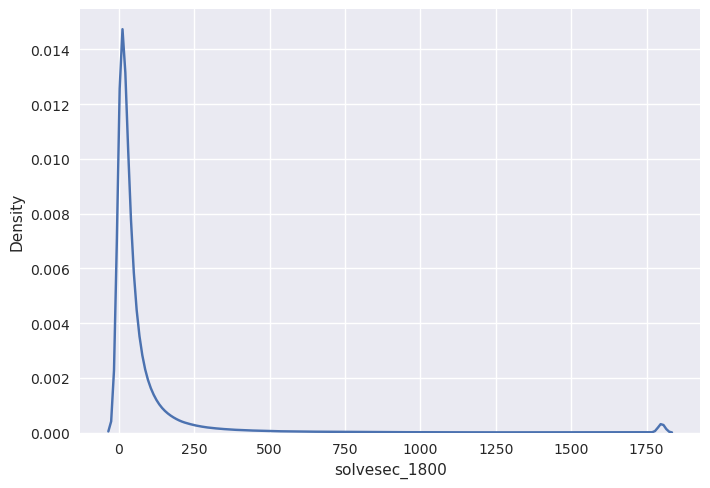

In [26]:
sns.kdeplot(df.solvesec_1800.dropna())

<AxesSubplot:xlabel='solvesec_1200', ylabel='Density'>

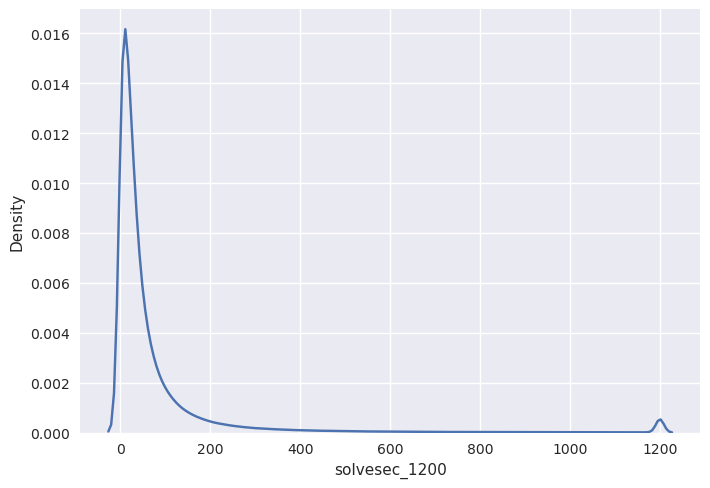

In [27]:
sns.kdeplot(df.solvesec_1200.dropna())

### time category 나누기

In [13]:
df['time_category'] = ''

tc = [0,5,7,10,60,600,1200,2400]
df.loc[(df.solvesec==0), 'time_category'] = "0 - [0,0]"
print(0)
for i in range(len(tc)-1):
    s,e = tc[i],tc[i+1]
    df.loc[(df.solvesec>s) & (df.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    print(s,e)
df.loc[(df.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
print(e)

0
0 5
5 7
7 10
10 60
60 600
600 1200
1200 2400
2400


In [14]:
df[:2]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Timestamp2,solvetime,solvesec,solvesec_3600,...,tag_mean,tag_std,tag_sum,kind,solvesec_3200,solvesec400,solvesec_1800,solvesec_1200,solvesec_800,solvesec_600
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,2020-03-24 00:17:11,NaT,NaN,NaN,...,0.955022,0.207410,637,train,NaN,NaN,NaN,NaN,NaN,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2020-03-24 00:17:14,0 days 00:00:03,3.0,3.0,...,0.913187,0.281603,3040,train,3.0,3.0,3.0,3.0,3.0,3.0


In [16]:
df.loc[df.time_category=='','time_category']='9999'

In [17]:
time_grp = df.groupby('time_category')['answerCode'].agg(['mean','count'])
time_grp['C'] = time_grp.index.str.extract(r'(\d+)').astype(int)[0].tolist()
time_grp.sort_values('C')[['mean','count']]

,mean,count
time_category,,
"0 - [0,0]",0.448999,8245
"1 - (0, 5]",0.245654,364504
"2 - (5, 7]",0.490895,69080
"3 - (7, 10]",0.664487,102023
"4 - (10, 60]",0.751336,1001011
"5 - (60, 600]",0.698406,529315
"6 - (600, 1200]",0.651418,20199
"7 - (1200, 2400]",0.650398,8544
"8 - (2400, )",0.703134,16590


In [31]:
timecat2idx={k:v for v,k in enumerate(sorted(df.time_category.unique()))}
df['time_category'] = df.time_category.map(timecat2idx)
df.time_category.value_counts()

4    1008903
5     552226
8     369582
1     364747
3     102204
2      69176
6      27384
7      16756
0       8280
9       7442
Name: time_category, dtype: int64

In [35]:
df[:10][['userID','time_category']]

,userID,time_category
0,0,9
1,0,1
2,0,3
3,0,2
4,0,2
5,0,4
6,0,8
7,0,2
8,0,5
9,0,4


In [36]:
df2 = df.drop(['Timestamp2','solvetime'],axis=1)
export(df2, output='after_fe_train_test_solvetime2.pkl')

Write: /opt/ml/input/data/after_fe_train_test_solvetime2.pkl
